In [5]:
from sklearn.model_selection   import train_test_split, StratifiedKFold
from sklearn.ensemble          import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics           import confusion_matrix, accuracy_score, f1_score, roc_curve
from sklearn.utils             import resample
from keras.utils               import to_categorical
from sklearn.cross_validation  import KFold
from keras.models              import Sequential
from keras.layers.core         import Dense, Dropout
from keras.callbacks           import EarlyStopping

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# Functions
def find_optimal_cutoff( target, predicted ):
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange( len( tpr ) )
    roc=pd.DataFrame({'tf':pd.Series(tpr-(1-fpr), index=i), 'threshold':pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]
    return list(roc_t['threshold'])

In [8]:
# Load dataset
print( '===> loading dataset' )
data = pd.read_csv( '~/bitbucket_repos/machine_learning/dataset/HR.csv' )
dataset = data.rename( columns = {'left':'class'} )

===> loading dataset


In [9]:
# Unbalanced dataset
# Upsampling
minority = dataset[ dataset['class'] == 1 ]
minority_upsampled = resample( minority, replace = True, n_samples = 11428, random_state = 123 )

In [11]:
# Downsampling
majority = dataset[ dataset['class'] == 0 ]
majority_downsampled = resample( majority, replace = False, n_samples = 3571, random_state = 123 )
dataset = pd.concat( [minority, majority_downsampled] )

In [12]:
# Transform features
dataset = pd.get_dummies( dataset, columns = ['sales', 'salary'] )

In [14]:
# Selection features
features = dataset.drop( 'class', axis = 1 )
labels = dataset[['class']]
rf = RandomForestClassifier( n_estimators = 100, criterion = 'entropy', max_depth = 15,
                             min_samples_leaf = 50, min_samples_split = 100, random_state = 10 )

In [15]:
# Train the selector
rf.fit( features, labels.values.ravel() )
features_imp = pd.Series(rf.feature_importances_,index=features.columns).sort_values(ascending=False)
print( 'features importance:\n', features_imp )

features importance:
 satisfaction_level       0.291109
time_spend_company       0.252124
number_project           0.157013
average_montly_hours     0.154936
last_evaluation          0.106245
Work_accident            0.016649
salary_low               0.008121
salary_high              0.005214
salary_medium            0.002544
sales_technical          0.001741
sales_sales              0.001323
sales_support            0.000672
sales_RandD              0.000447
promotion_last_5years    0.000416
sales_marketing          0.000284
sales_hr                 0.000277
sales_management         0.000274
sales_product_mng        0.000252
sales_IT                 0.000192
sales_accounting         0.000168
dtype: float64


In [16]:
criteria = rf.feature_importances_ >  0.155
features = features.iloc[:, criteria ]
print( pd.DataFrame({'Main Features': features.columns} ) )

        Main Features
0  satisfaction_level
1      number_project
2  time_spend_company


In [19]:
# Split dataset - Train and Test dataset
trainX, testX, trainY, testY = train_test_split( features, labels, test_size = 0.2 )

trainX = trainX.as_matrix()
trainY = to_categorical( trainY, num_classes = 2 )


testX = testX.as_matrix()
testY = to_categorical( testY, num_classes = 2 )

In [20]:
# Cross-Validation
results = []
i = 0
n_folds = 10
cv = KFold( len( trainX ), n_folds = n_folds )
callbacks = [EarlyStopping( monitor = 'val_loss', patience = 2 )]
for traincv, testcv in cv:
    print( '===> running fold', i+1, '/', n_folds )
    # Train
    mlp = Sequential()
    mlp.add(Dense(100, input_dim=trainX.shape[1], kernel_initializer='random_uniform',bias_initializer='random_uniform', activation='relu'))
    mlp.add( Dense( 2, kernel_initializer='random_uniform', bias_initializer = 'random_uniform', activation='sigmoid' ) )
    mlp.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )
    mlp.fit( trainX[traincv], trainY[traincv], batch_size=64, epochs=50, verbose=0, validation_split=0.3, callbacks=callbacks )
    # Test
    predicted = mlp.predict_proba( trainX[testcv] )
    predicted = np.where( predicted[:,0] > 0.5, 1, 0 )
    acc = accuracy_score( trainY[testcv,0], predicted )
    print( '\naccuracy:', acc )
    results.append( acc )
    i += 1
print( 'Results:', str( 100*np.array( results ).mean() ), '+/-', str( np.array( results ).std() ) )

===> running fold 1 / 10

accuracy: 0.902097902098
===> running fold 2 / 10

accuracy: 0.868881118881
===> running fold 3 / 10

accuracy: 0.886363636364
===> running fold 4 / 10

accuracy: 0.870402802102
===> running fold 5 / 10

accuracy: 0.893169877408
===> running fold 6 / 10

accuracy: 0.900175131349
===> running fold 7 / 10

accuracy: 0.887915936953
===> running fold 8 / 10

accuracy: 0.880910683012
===> running fold 9 / 10

accuracy: 0.896672504378
===> running fold 10 / 10

accuracy: 0.872154115587
Results: 88.5874370813 +/- 0.0117599738391


In [25]:
# Training model - MLP
mlp = Sequential()
mlp.add( Dense( 100, input_dim=trainX.shape[1], kernel_initializer='random_uniform', bias_initializer='random_uniform', activation='relu') )
mlp.add( Dense( 2, kernel_initializer='random_uniform', bias_initializer = 'random_uniform', activation='sigmoid' ) ) # Output Layer
mlp.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

# Training
callbacks = [EarlyStopping( monitor = 'val_loss', patience = 2 )]
mlp_info = mlp.fit( trainX, trainY, batch_size=64, epochs=50, verbose=2, validation_split=0.3, callbacks = callbacks )

Train on 3999 samples, validate on 1714 samples
Epoch 1/50
 - 1s - loss: 0.6854 - acc: 0.6227 - val_loss: 0.6735 - val_acc: 0.7392
Epoch 2/50
 - 0s - loss: 0.6498 - acc: 0.7976 - val_loss: 0.6199 - val_acc: 0.8317
Epoch 3/50
 - 0s - loss: 0.5851 - acc: 0.8370 - val_loss: 0.5493 - val_acc: 0.8466
Epoch 4/50
 - 0s - loss: 0.5232 - acc: 0.8436 - val_loss: 0.4965 - val_acc: 0.8419
Epoch 5/50
 - 0s - loss: 0.4766 - acc: 0.8456 - val_loss: 0.4538 - val_acc: 0.8518
Epoch 6/50
 - 0s - loss: 0.4410 - acc: 0.8538 - val_loss: 0.4266 - val_acc: 0.8498
Epoch 7/50
 - 0s - loss: 0.4159 - acc: 0.8586 - val_loss: 0.4040 - val_acc: 0.8611
Epoch 8/50
 - 0s - loss: 0.3953 - acc: 0.8621 - val_loss: 0.3836 - val_acc: 0.8757
Epoch 9/50
 - 0s - loss: 0.3790 - acc: 0.8682 - val_loss: 0.3726 - val_acc: 0.8708
Epoch 10/50
 - 0s - loss: 0.3668 - acc: 0.8745 - val_loss: 0.3616 - val_acc: 0.8702
Epoch 11/50
 - 0s - loss: 0.3565 - acc: 0.8771 - val_loss: 0.3531 - val_acc: 0.8816
Epoch 12/50
 - 0s - loss: 0.3497 - ac

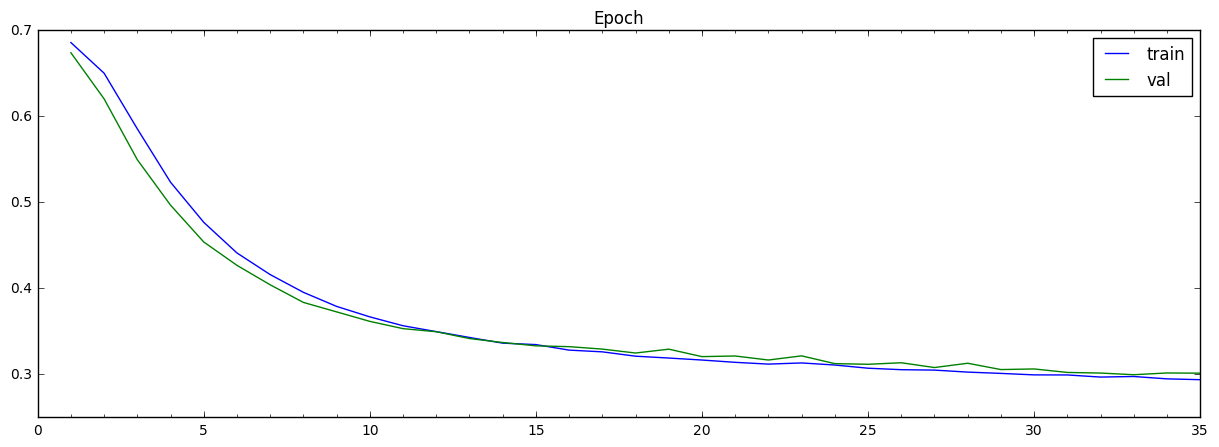

In [26]:
# Training Error
fig, axs = plt.subplots( figsize = ( 15, 5 ) )
axs.plot( range( 1, len( mlp_info.history['loss'] ) + 1 ), mlp_info.history['loss'] )
axs.plot( range( 1, len( mlp_info.history['val_loss'] ) + 1 ), mlp_info.history['val_loss'] )
axs.set_title( 'Model Loss' )
axs.set_title( 'Loss' )
axs.set_title( 'Epoch' )
axs.set_xticks( np.arange( 1,len(mlp_info.history['loss'] )+1), len(mlp_info.history['loss'])/10 )
axs.legend( ['train', 'val'], loc = 'best' )
plt.show()

In [27]:
# Performance model over Test Dataset
predicted = mlp.predict_proba( testX )
threshold = find_optimal_cutoff( testY[:,0], predicted[:,0] )
print( '\nthreshold:', threshold[0] )
predicted = np.where( predicted[:,0] > threshold, 1, 0 )


threshold: 0.428235


In [29]:
# Metrics
# Accuracy
acc = accuracy_score( testY[:,0], predicted )
print( 'accuracy:', acc )

# Confusion Matrix
cm = confusion_matrix( testY[:,0], predicted )
print( cm )

# F1-score
f1 = f1_score( testY[:,0], predicted )
print( 'f1-score:', f1 )


accuracy: 0.904828551435
[[655  69]
 [ 67 638]]
f1-score: 0.903682719547


In [30]:
print( '===> well done' )

===> well done
